# MedDef 1.0: An Attention based Model for Adversarial Resilience in Medical Image Analysis

In [32]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Add the current directory to the path for imports
sys.path.append(os.getcwd())

# Import our modules
from loader.dataset_handler import DatasetHandler
from loader.dataset_loader import DatasetLoader

# Load datasets
### Dataset Class




In [33]:
# Set paths
DATA_PATH = Path("processed_data")
OUTPUT_DIR = Path("out/dataset_analysis")

In [34]:
# # Configure plots
# plt.rcParams["figure.figsize"] = (12, 8)
# plt.style.use('seaborn-v0_8-whitegrid')

In [35]:
# Set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
# Define helper functions for visualization
def show_batch(dataloader, title="Sample Images", max_images=16):
    # Get a batch from the dataloader
    images, labels = next(iter(dataloader))
    images = images[:max_images]
    labels = labels[:max_images]
    
    # Convert to grid
    grid = make_grid(images, nrow=4, normalize=True)
    
    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=16)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    
    # Add class labels below
    class_names = dataloader.dataset.classes if hasattr(dataloader.dataset, 'classes') else [
        str(i) for i in range(len(images))]
    
    # For ImageFolder datasets accessed through DataLoader
    if hasattr(dataloader.dataset, 'dataset') and hasattr(dataloader.dataset.dataset, 'classes'):
        class_names = dataloader.dataset.dataset.classes
    
    plt.figure(figsize=(12, 3))
    for i in range(min(len(images), max_images)):
        plt.subplot(1, min(len(images), max_images), i+1)
        plt.text(0.5, 0.5, class_names[labels[i]], 
                 horizontalalignment='center', verticalalignment='center', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [37]:
def plot_class_distribution(dataloader, title="Class Distribution"):
    # Collect all labels from dataloader
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())
    
    # Convert to numpy array
    all_labels = np.array(all_labels)
    
    # Get class names
    class_names = dataloader.dataset.classes if hasattr(dataloader.dataset, 'classes') else [
        str(i) for i in range(len(np.unique(all_labels)))]
    
    # For ImageFolder datasets accessed through DataLoader
    if hasattr(dataloader.dataset, 'dataset') and hasattr(dataloader.dataset.dataset, 'classes'):
        class_names = dataloader.dataset.dataset.classes
    
    # Count class occurrences
    unique_classes, counts = np.unique(all_labels, return_counts=True)
    
    # Create DataFrame for easy plotting
    df = pd.DataFrame({
        'Class': [class_names[i] for i in unique_classes],
        'Count': counts
    })
    
    # Sort by count for better visualization
    df = df.sort_values('Count', ascending=False)
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.title(title, fontsize=16)
    ax = sns.barplot(x='Class', y='Count', data=df)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add count labels on top of bars
    for i, count in enumerate(df['Count']):
        ax.text(i, count + 5, str(count), ha='center')
    
    plt.show()

In [38]:
def plot_image_properties(dataloader, title="Image Properties Distribution"):
    # Collect image properties
    dimensions = []
    channels = []
    
    for images, _ in dataloader:
        batch_size, n_channels, height, width = images.shape
        for i in range(batch_size):
            dimensions.append((height, width))
            channels.append(n_channels)
    
    # Convert to numpy arrays
    dimensions = np.array(dimensions)
    channels = np.array(channels)
    
    # Plot dimensions
    plt.figure(figsize=(14, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(1, 2, 1)
    plt.title("Image Dimensions")
    plt.scatter(dimensions[:, 1], dimensions[:, 0], alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.title("Channel Distribution")
    channel_counts = np.unique(channels, return_counts=True)
    plt.bar([f"{c} channels" for c in channel_counts[0]], channel_counts[1])
    plt.xlabel('Number of Channels')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

In [39]:
def visualize_dataset_info(dataset_name):
    """Visualize dataset information by reading the dataset_info.txt file"""
    info_path = OUTPUT_DIR / dataset_name / 'dataset_info.txt'
    
    if not info_path.exists():
        print(f"No dataset info found at {info_path}")
        return
    
    # Read and display dataset info
    with open(info_path, 'r') as f:
        info_content = f.read()
    
    print(f"Dataset Information for {dataset_name}:")
    print("="*80)
    print(info_content)
    print("="*80)
    print("\n")

In [40]:
def visualize_tsne(dataloader, title="t-SNE Visualization", n_samples=1000):
    """Visualize dataset using t-SNE dimensionality reduction"""
    # Collect samples and labels
    all_images = []
    all_labels = []
    for images, labels in dataloader:
        all_images.append(images)
        all_labels.append(labels)
        if len(all_images) * images.shape[0] >= n_samples:
            break
    
    # Convert to tensors
    all_images = torch.cat(all_images)[:n_samples]
    all_labels = torch.cat(all_labels)[:n_samples]
    
    # Flatten images
    flattened = all_images.view(all_images.shape[0], -1).numpy()
    
    # Apply PCA first to reduce dimensions (speed up t-SNE)
    print("Computing PCA...")
    pca = PCA(n_components=min(50, flattened.shape[1], flattened.shape[0]))
    reduced_data = pca.fit_transform(flattened)
    
    # Apply t-SNE
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    tsne_result = tsne.fit_transform(reduced_data)
    
    # Plot results
    plt.figure(figsize=(12, 10))
    plt.title(title, fontsize=16)
    
    # Get class names
    class_names = dataloader.dataset.classes if hasattr(dataloader.dataset, 'classes') else [
        str(i) for i in range(len(np.unique(all_labels)))]
    
    # For ImageFolder datasets accessed through DataLoader
    if hasattr(dataloader.dataset, 'dataset') and hasattr(dataloader.dataset.dataset, 'classes'):
        class_names = dataloader.dataset.dataset.classes
    
    # Plot each class with different color
    unique_labels = all_labels.unique().numpy()
    for label in unique_labels:
        idx = all_labels == label
        plt.scatter(
            tsne_result[idx, 0], 
            tsne_result[idx, 1], 
            label=class_names[label],
            alpha=0.6
        )
    
    plt.legend()
    plt.show()


In [41]:
# Function to analyze and visualize a dataset
def analyze_dataset(dataset_name):
    print(f"\n{'='*80}")
    print(f"Analyzing Dataset: {dataset_name}")
    print(f"{'='*80}")
    
    # Display dataset info from txt file
    visualize_dataset_info(dataset_name)
    
    try:
        # Method 1: Using DatasetLoader (your original class)
        loader = DatasetLoader()
        batch_size = {'train': 32, 'val': 32, 'test': 32}
        train_loader, val_loader, test_loader = loader.load_data(dataset_name, batch_size)
        
        print(f"Successfully loaded {dataset_name} using DatasetLoader")
        print(f"Train samples: {len(train_loader.dataset)}")
        print(f"Validation samples: {len(val_loader.dataset)}")
        print(f"Test samples: {len(test_loader.dataset)}")
        print(f"Classes: {train_loader.dataset.classes}")
        print("\n")
        
    except Exception as e:
        print(f"Error with DatasetLoader: {str(e)}")
        print("Trying with DatasetHandler instead...")
        
        try:
            # Method 2: Using DatasetHandler
            handler = DatasetHandler(dataset_name)
            train_loader, val_loader, test_loader = handler.process_and_load(
                OUTPUT_DIR,
                train_batch_size=32,
                val_batch_size=32,
                test_batch_size=32
            )
            
            print(f"Successfully loaded {dataset_name} using DatasetHandler")
            print(f"Train samples: {len(train_loader.dataset)}")
            print(f"Validation samples: {len(val_loader.dataset)}")
            print(f"Test samples: {len(test_loader.dataset)}")
            print("\n")
            
        except Exception as e2:
            print(f"Error with DatasetHandler: {str(e2)}")
            print("Both loading methods failed. Skipping dataset.")
            return
    
    # Visualize the dataset
    print("Showing sample images from training set...")
    show_batch(train_loader, title=f"{dataset_name} - Training Samples")
    
    print("Plotting class distribution...")
    plot_class_distribution(train_loader, title=f"{dataset_name} - Class Distribution")
    
    print("Analyzing image properties...")
    plot_image_properties(train_loader, title=f"{dataset_name} - Image Properties")
    
    print("Computing t-SNE visualization...")
    try:
        # Use a smaller dataloader for t-SNE to avoid memory issues
        small_loader = DataLoader(
            train_loader.dataset, 
            batch_size=64,
            shuffle=True,
            num_workers=0
        )
        visualize_tsne(small_loader, title=f"{dataset_name} - t-SNE Visualization", n_samples=500)
    except Exception as e:
        print(f"Error during t-SNE visualization: {str(e)}")
    
    print(f"Completed analysis of {dataset_name}")

Available datasets:
1. ccts
2. scisic
3. rotc
4. dermnet
5. chest_xray



Analyzing Dataset: ccts
No dataset info found at out/dataset_analysis/ccts/dataset_info.txt
Successfully loaded ccts using DatasetLoader
Train samples: 613
Validation samples: 72
Test samples: 315
Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


Showing sample images from training set...


<ipython-input-36-ccdf5c2f8155>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


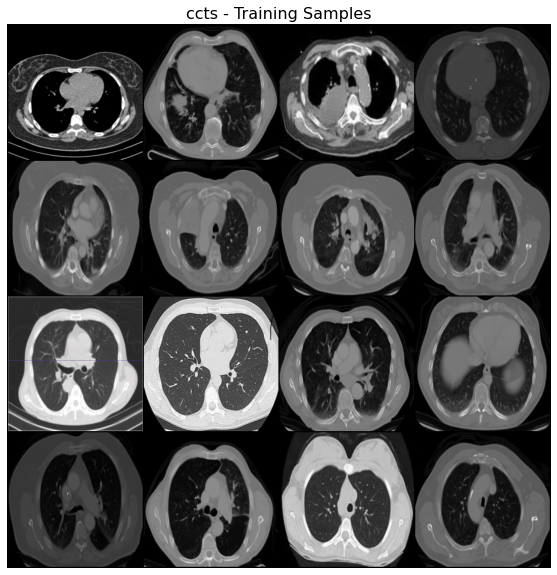

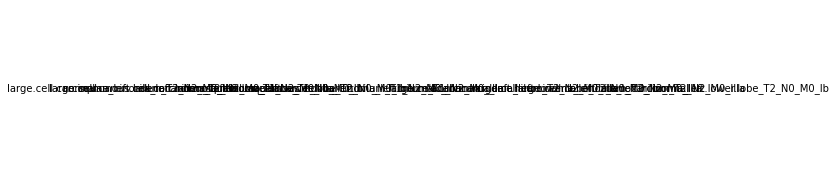

Plotting class distribution...


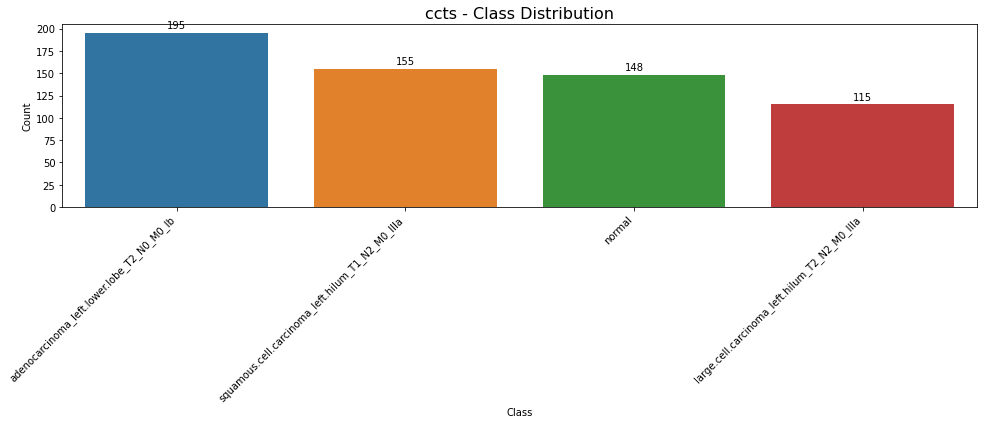

Analyzing image properties...


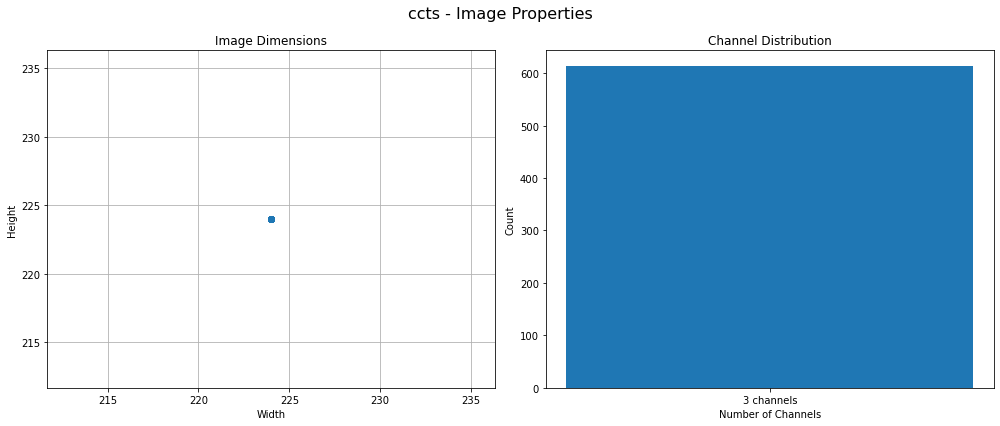

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feea4672f70>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


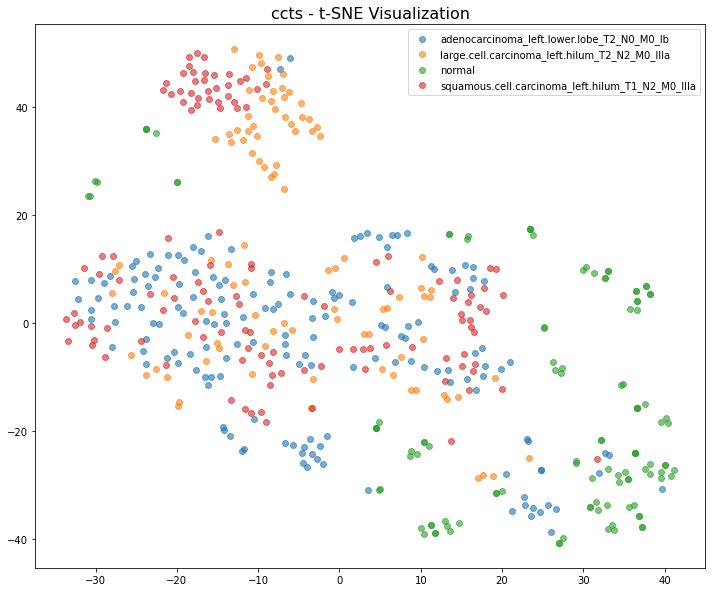

Completed analysis of ccts

Analyzing Dataset: scisic
No dataset info found at out/dataset_analysis/scisic/dataset_info.txt
Successfully loaded scisic using DatasetLoader
Train samples: 1898
Validation samples: 341
Test samples: 118
Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Showing sample images from training set...


<ipython-input-36-ccdf5c2f8155>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


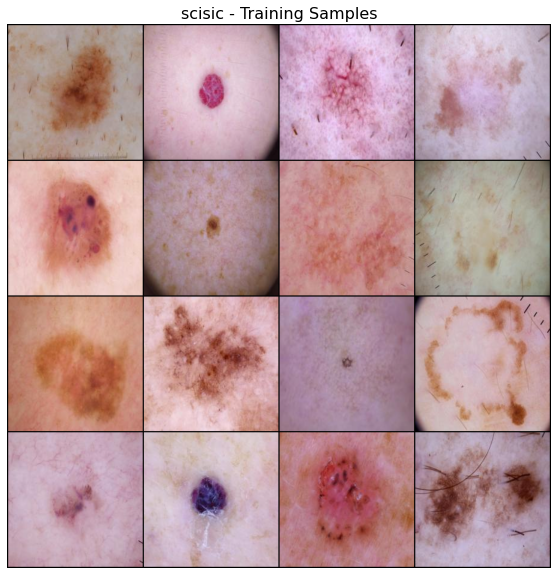

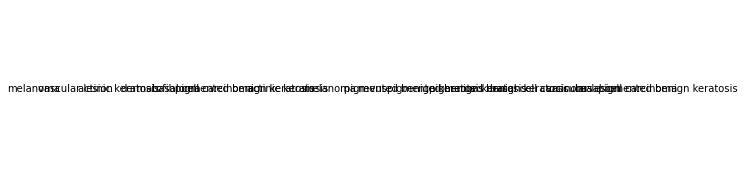

Plotting class distribution...


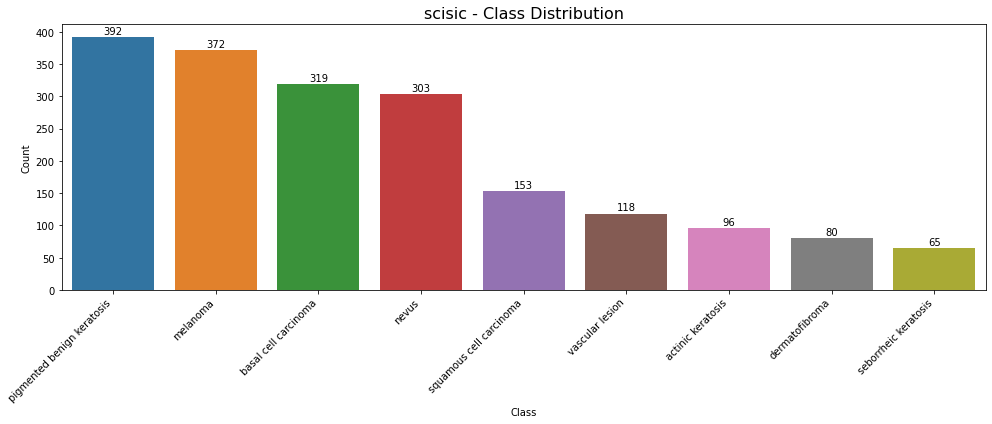

Analyzing image properties...


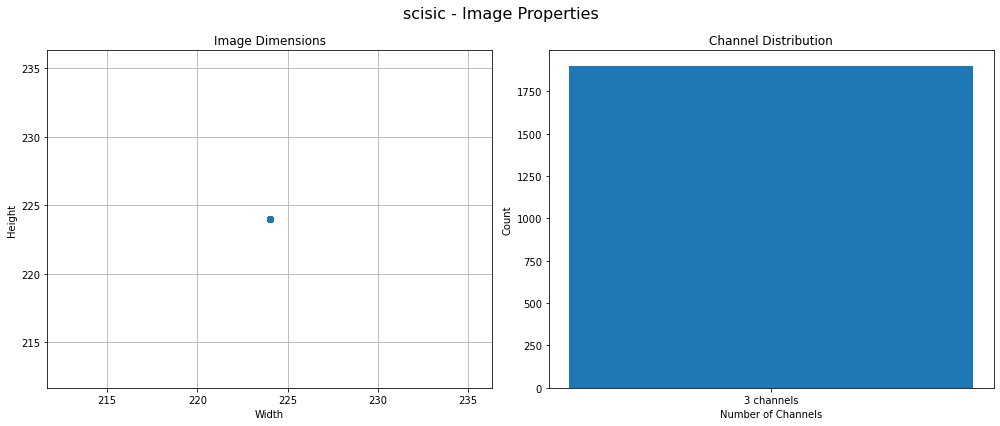

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fee999529d0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


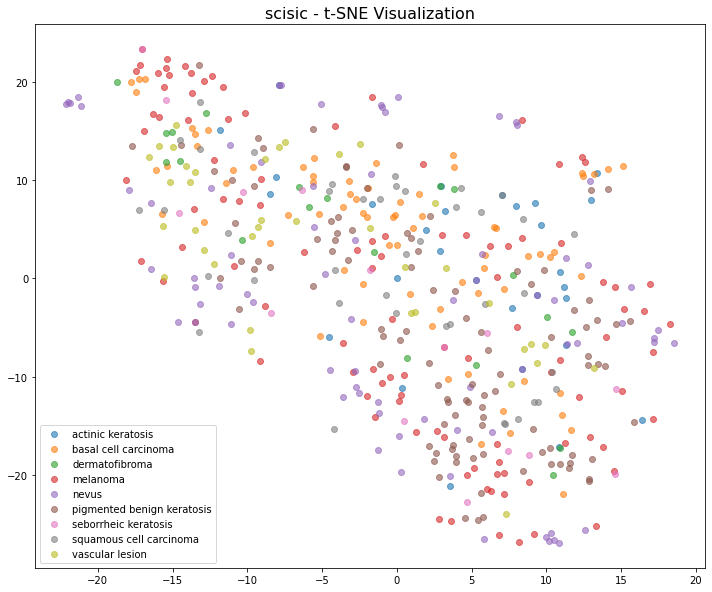

Completed analysis of scisic

Analyzing Dataset: rotc
No dataset info found at out/dataset_analysis/rotc/dataset_info.txt
Successfully loaded rotc using DatasetLoader
Train samples: 83484
Validation samples: 32
Test samples: 968
Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


Showing sample images from training set...


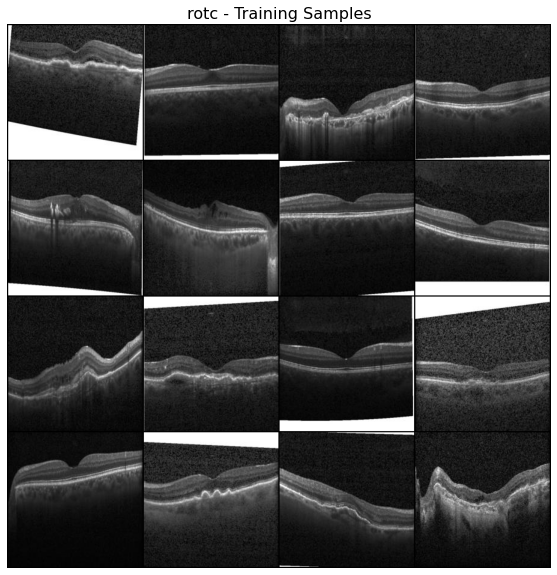

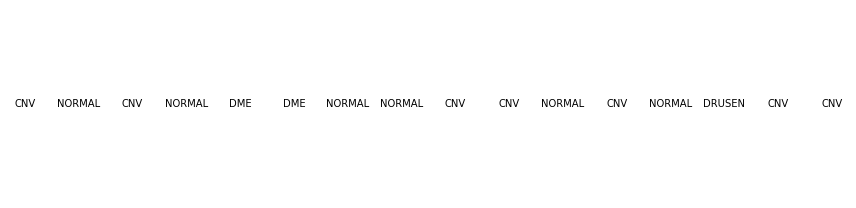

Plotting class distribution...


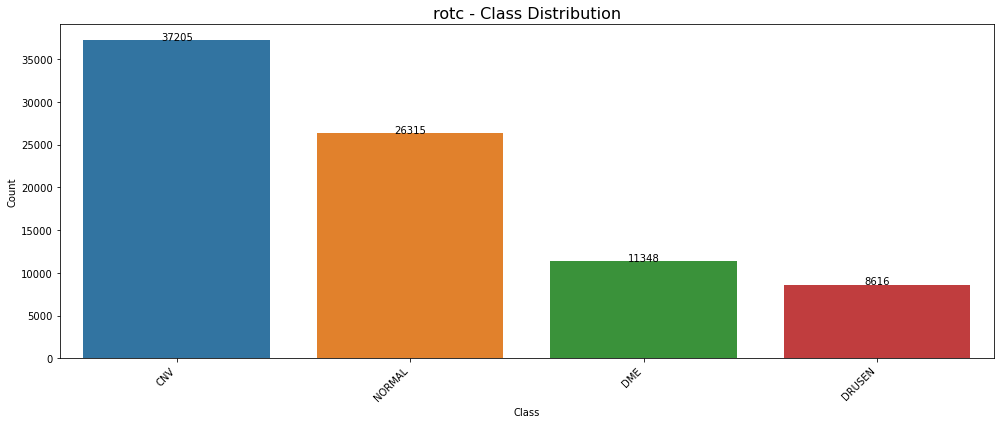

Analyzing image properties...


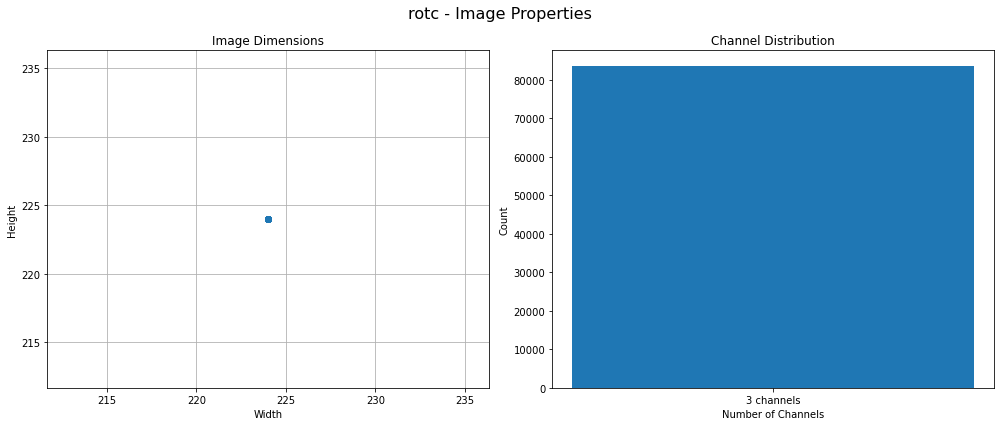

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feea39178b0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


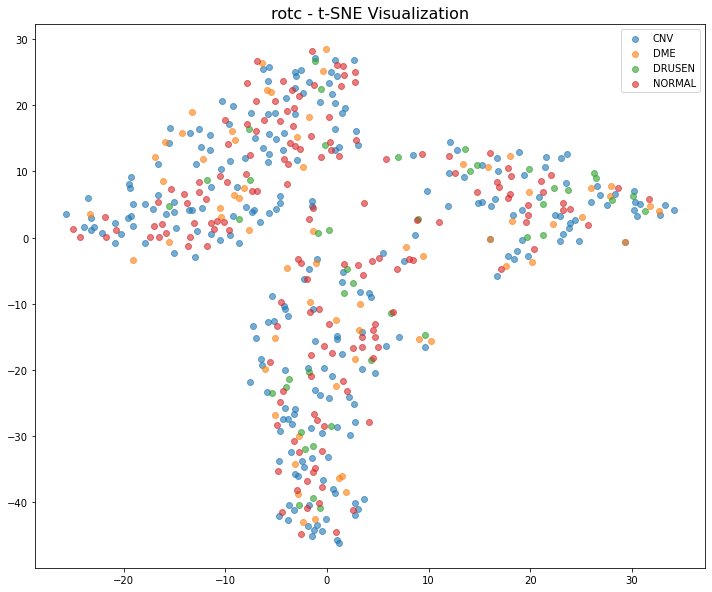

Completed analysis of rotc

Analyzing Dataset: dermnet
No dataset info found at out/dataset_analysis/dermnet/dataset_info.txt
Successfully loaded dermnet using DatasetLoader
Train samples: 13215
Validation samples: 2342
Test samples: 4002
Classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tine

<ipython-input-36-ccdf5c2f8155>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


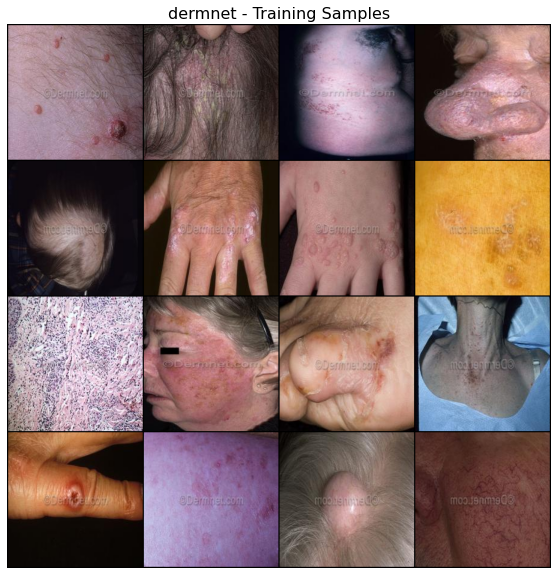

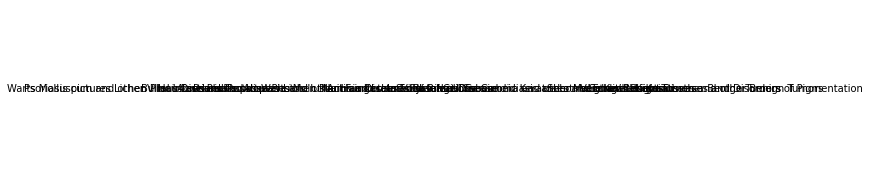

Plotting class distribution...


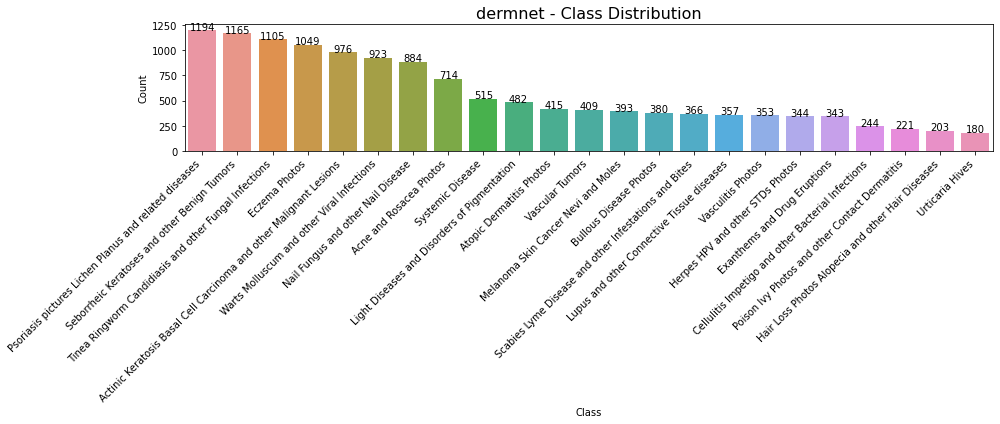

Analyzing image properties...


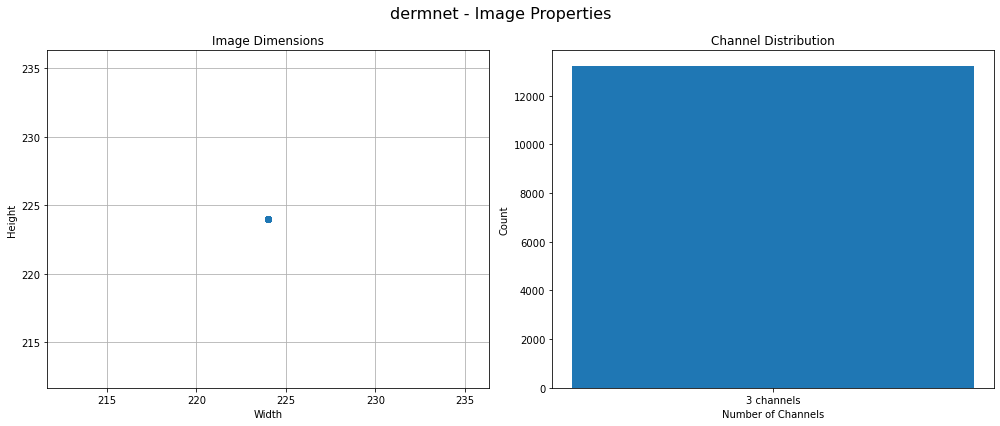

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feea3308d30>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


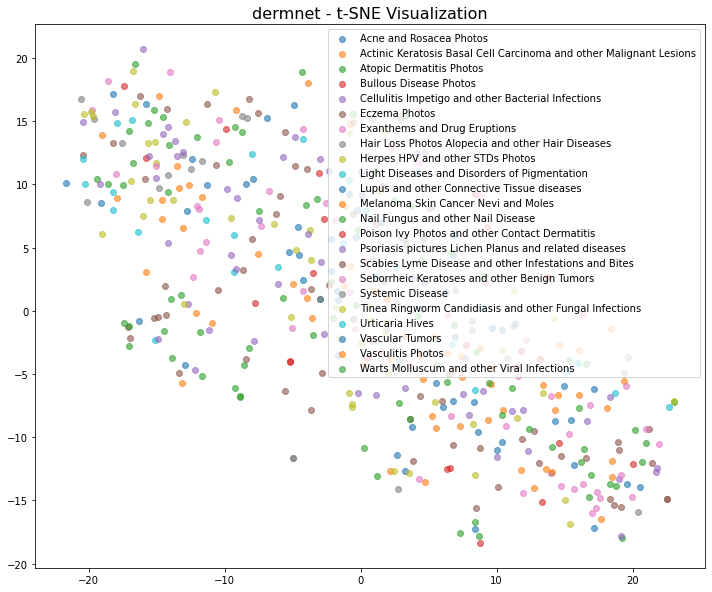

Completed analysis of dermnet

Analyzing Dataset: chest_xray
No dataset info found at out/dataset_analysis/chest_xray/dataset_info.txt
Successfully loaded chest_xray using DatasetLoader
Train samples: 5216
Validation samples: 16
Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']


Showing sample images from training set...


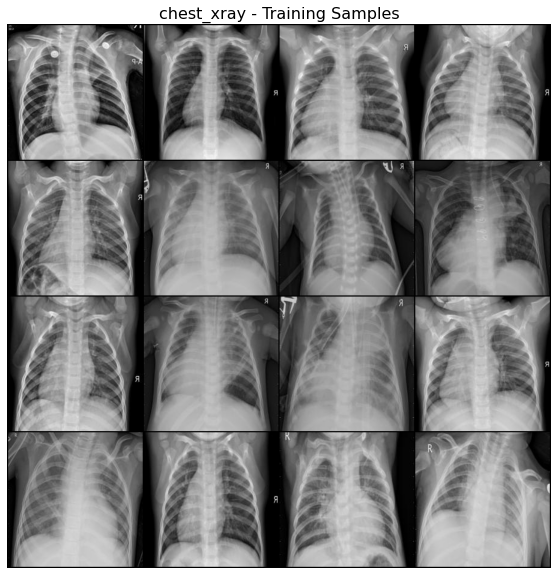

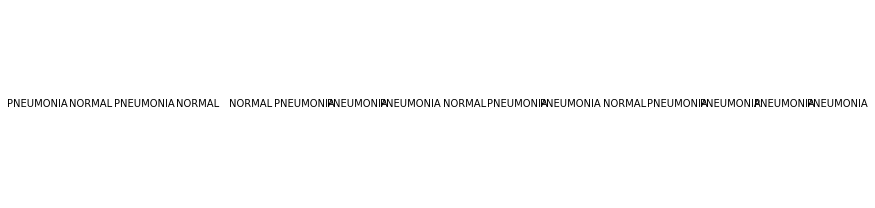

Plotting class distribution...


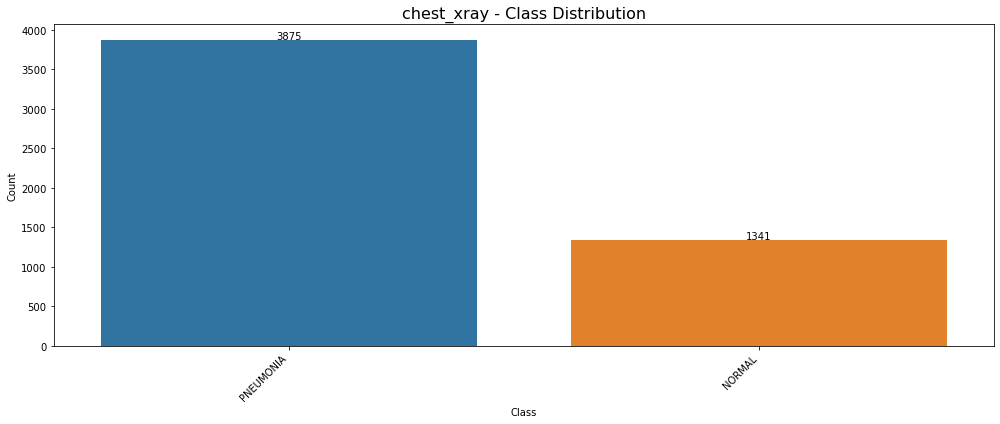

Analyzing image properties...


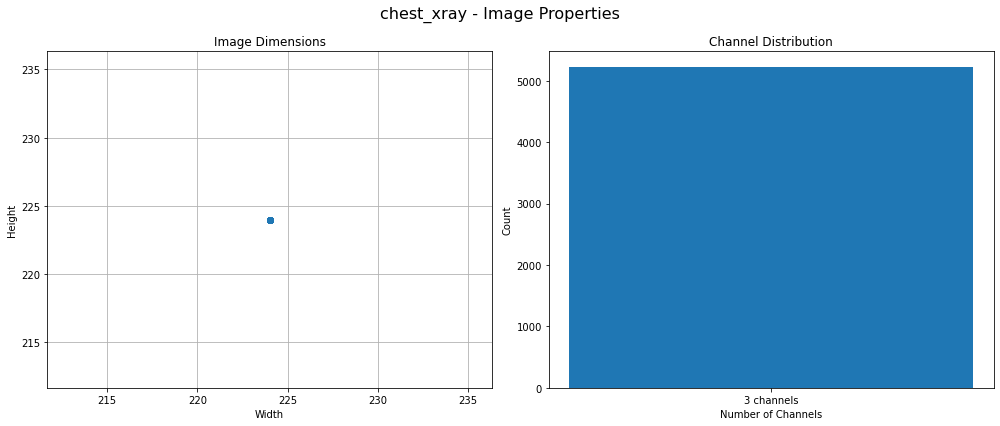

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feea49f70d0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


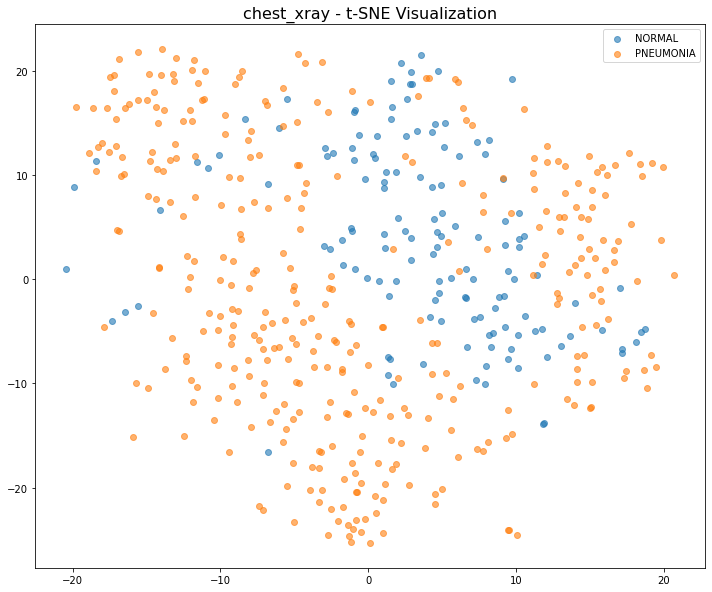

Completed analysis of chest_xray


In [42]:
# Main execution block
if __name__ == "__main__":
    # List of datasets to analyze
    datasets = [
        'ccts', 
        'scisic', 
        'rotc', 
        # 'kvasir', 
        'dermnet',
        'chest_xray', 
        # 'tbcr', 
        # 'miccai_brats2020'
    ]
    
    # Allow user to select which datasets to analyze
    print("Available datasets:")
    for i, name in enumerate(datasets):
        print(f"{i+1}. {name}")
    
    selected = input("Enter dataset numbers to analyze (comma-separated), or 'all' for all datasets: ")
    
    if selected.lower() == 'all':
        selected_datasets = datasets
    else:
        indices = [int(idx.strip()) - 1 for idx in selected.split(",")]
        selected_datasets = [datasets[i] for i in indices if 0 <= i < len(datasets)]
    
    # Analyze each selected dataset
    for dataset_name in selected_datasets:
        analyze_dataset(dataset_name)

In [43]:
# # Understanding the dataset

# def display_image(image, title, ax, dataset_name=None):
#     if image is None:
#         raise ValueError("Input image is None.")
#     if not isinstance(image, (np.ndarray, torch.Tensor, np.memmap)):
#         raise TypeError("Unsupported image type. Must be np.ndarray, torch.Tensor, or np.memmap.")

#     print(f"Initial image type: {type(image)}, shape: {image.shape}")

#     if isinstance(image, np.memmap):
#         image = np.array(image)
#         print(f"Converted from memmap to ndarray, shape: {image.shape}")

#     if isinstance(image, torch.Tensor):
#         image = image.detach().cpu().numpy()
#         print(f"Converted from tensor to ndarray, shape: {image.shape}")

#     if image.ndim not in [2, 3, 4]:
#         raise ValueError(f"Unsupported image dimensions: {image.ndim}. Expected 2D, 3D, or 4D image.")

#     if image.ndim == 4:
#         image = image[:, :, :, image.shape[3] // 2]
#         print(f"Selected middle slice for 4D image, new shape: {image.shape}")

#     if image.ndim == 3:
#         if image.shape[0] in [1, 3]:
#             image = np.transpose(image, (1, 2, 0))
#             print(f"Transposed 3D image to (H, W, C), new shape: {image.shape}")

#     if image.ndim == 3 and image.shape[-1] == 1:
#         image = np.squeeze(image, axis=-1)
#         print(f"Squeezed single-channel image, new shape: {image.shape}")

#     if image.dtype == np.float32 or image.max() <= 1.0:
#         image = np.clip(image * 255, 0, 255).astype(np.uint8)
#         print(f"Scaled image to 0-255 range, dtype: {image.dtype}")

#     if image.ndim == 2:
#         image = np.stack([image] * 3, axis=-1)
#         print(f"Converted 2D grayscale image to 3D RGB, new shape: {image.shape}")

#     try:
#         pil_image = Image.fromarray(image.astype(np.uint8))
#         print(f"Converted image to PIL format, mode: {pil_image.mode}")
#     except Exception as e:
#         raise ValueError(f"Error converting image to PIL format: {e}")

#     ax.imshow(pil_image, cmap='gray' if pil_image.mode == 'L' else None)
#     ax.set_title(title)
#     ax.axis('off')


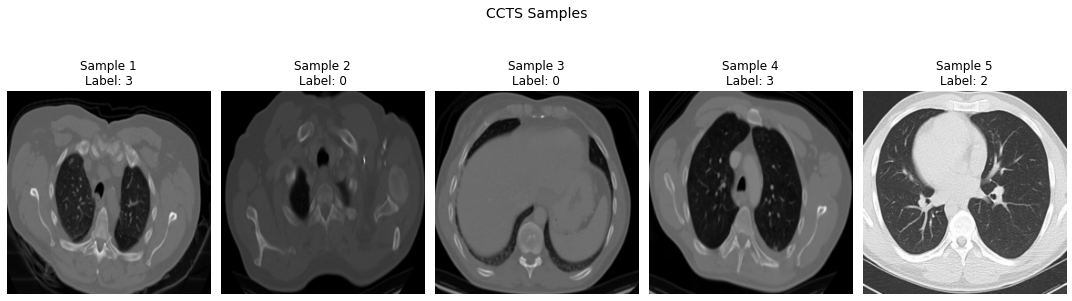

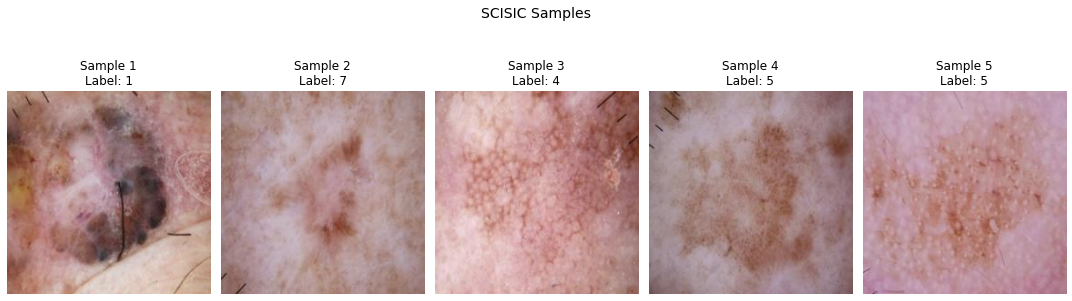

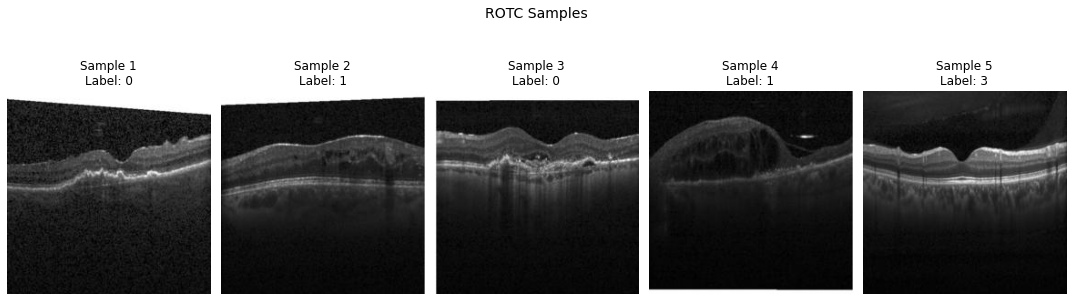

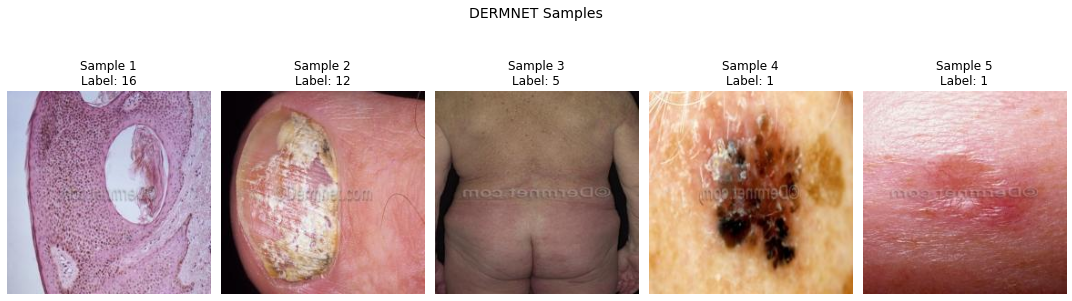

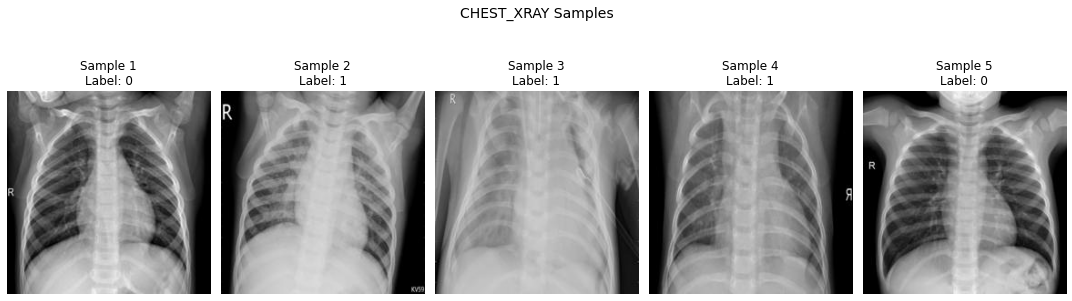

In [44]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch
from loader.dataset_loader import DatasetLoader

def display_image(image, title, ax):
    """Helper function to display a single image"""
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    # Transpose if necessary (CHW -> HWC)
    if image.shape[0] in [1, 3]:
        image = np.transpose(image, (1, 2, 0))
    
    # Handle grayscale images
    if image.shape[-1] == 1:
        image = image.squeeze()
        
    ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    ax.set_title(title)
    ax.axis('off')

def display_datasets(num_samples=5):
    """Display samples from all available datasets"""
    # List of available datasets
    datasets = ['ccts', 'scisic', 'rotc', 'dermnet', 'chest_xray']
    
    # Initialize dataset loader
    loader = DatasetLoader()
    
    for dataset_name in datasets:
        try:
            # Configure batch sizes
            batch_size = {
                'train': 1,
                'val': 1,
                'test': 1
            }
            
            # Load dataset
            logging.info(f"Loading dataset: {dataset_name}")
            train_loader, _, _ = loader.load_data(
                dataset_name=dataset_name,
                batch_size=batch_size,
                num_workers=0,
                pin_memory=False
            )
            
            # Create plot
            fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
            axes = [axes] if num_samples == 1 else axes
            fig.suptitle(f"{dataset_name.upper()} Samples", fontsize=14)
            
            # Display samples
            for i, (image, label) in enumerate(train_loader):
                if i >= num_samples:
                    break
                display_image(
                    image=image[0],  # Get first image from batch
                    title=f"Sample {i+1}\nLabel: {label[0].item()}",
                    ax=axes[i]
                )
            
            plt.tight_layout()
            plt.show()

        except Exception as e:
            logging.error(f"Error processing {dataset_name}: {str(e)}")
            continue

# Setup logging
logging.basicConfig(level=logging.INFO)

# Run visualization
display_datasets()

In [45]:
# Check the head of each dataset
# Call the function to print the head of each dataset
